In [2]:
!pip install -q transformers timm accelerate

In [4]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from PIL import Image
import torch

In [5]:
import zipfile
import pandas as pd

zip_path = "/content/my_dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/my_data")

print("解压完成！")

final_df = pd.read_csv("/content/my_data/final_df.csv")
print("Final df shape:", final_df.shape)
final_df.head()


解压完成！
Final df shape: (2951, 10)


,image_file,media_key,id,author_id,text,created_at,lang,Type,Lang,Stance
0,3_474839307350728704.jpg,3_474839307350728704,674953179365294082,453893556,#UNFAO success stories: Gaining traction on #c...,2015-12-10T14:05:52.000Z,en,Scientific actors,en,Unclear
1,3_657882574338048001.jpg,3_657882574338048001,674876637025054720,453893556,Tools for integrating gender in project &amp; ...,2015-12-10T09:01:43.000Z,en,Scientific actors,en,Unclear
2,3_664051360032235521.jpg,3_664051360032235521,671344441089634305,417856150,An ambitious deal at #COP21 is the 1st step to...,2015-11-30T15:06:02.000Z,en,Scientific actors,en,For
3,3_664051360032235521.jpg,3_664051360032235521,671272489452879872,417856150,"#BackClimateAction to limit heatwaves, water s...",2015-11-30T10:20:07.000Z,en,Scientific actors,en,For
4,3_664086251616735232.jpg,3_664086251616735232,672360907494715392,417856150,Why we need #cities to #BackClimateAction - bl...,2015-12-03T10:25:06.000Z,en,Scientific actors,en,For


In [6]:
# 加载 OWL-ViT 模型（Open Vocabulary Detector）
from PIL import Image
from collections import Counter
import os

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [48]:
def extract_objects(img_path, threshold=0.05):
    image = Image.open(img_path).convert("RGB")

    # 1. 文本提示
    query = ["leader", "presenter", "meeting", "press", "snow","wind",'tree','forest','lake']

    # 2. 处理输入
    inputs = processor(text=query, images=image, return_tensors="pt")

    # 3. 推理
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. 获取 logits（1, num_queries, num_text_queries）
    logits = outputs.logits[0]     # shape: [num_queries, num_text_queries]
    boxes = outputs.pred_boxes[0]  # shape: [num_queries, 4]

    # 5. 转成概率
    probs = logits.sigmoid()

    detected = []

    # 6. 遍历所有 proposals & 所有文本类别
    num_queries, num_text_classes = probs.shape
    for i in range(num_queries):
        for j in range(num_text_classes):
            score = probs[i, j].item()
            if score >= threshold:
                detected.append({
                    "label": query[j],
                    "score": round(score, 3),
                    "box": boxes[i].tolist()
                })

    return detected


In [49]:
import os

# ⭐ 随机抽样 100 张做实验
sample_df = final_df.sample(100, random_state=666).reset_index(drop=True)

bow_results = []

for idx, row in sample_df.iterrows():

    img_path = f"/content/my_data/images/{row['image_file']}"

    # 如果图片路径不存在就跳过
    if not os.path.exists(img_path):
        print("❌ 找不到图片:", img_path)
        bow_results.append({"objects": []})
        continue

    # ⭐ 调用你刚写好的函数！
    objs = extract_objects(img_path)
    bow_results.append({"objects": objs})

# 把结果加入 df
sample_df["objects"] = [x["objects"] for x in bow_results]

sample_df.head()


,image_file,media_key,id,author_id,text,created_at,lang,Type,Lang,Stance,objects
0,3_674261885475164160.jpg,3_674261885475164160,674261886985195521,329628561,Our panel with @PRI_News @SycomoreAM @DemeterP...,2015-12-08T16:18:55.000Z,en,Business actors,en,For,"[{'label': 'presenter', 'score': 0.053, 'box':..."
1,3_673533167819579392.jpg,3_673533167819579392,673536371810836484,3008051701,"Energy4Europe: RE-Energising our future, but f...",2015-12-06T16:15:59.000Z,en,Business actors,en,For,[]
2,3_672084703390924801.jpg,3_672084703390924801,672084719190867968,3288510261,All set up: We've arrived at #COP21. Find us i...,2015-12-02T16:07:38.000Z,en,Scientific actors,en,For,[]
3,3_671268717817294848.jpg,3_671268717817294848,671268718563995648,95687779,#Climatesolutions @veolia: In Rostock #Germany...,2015-11-30T10:05:08.000Z,en,Business actors,en,For,[]
4,3_671902027887337474.jpg,3_671902027887337474,671902027971223552,65339733,The world needs clarity on the way to reduce g...,2015-12-02T04:01:41.000Z,en,Scientific actors,en,For,[]



# 1.2  Bag of words



In [50]:
# STEP 1：把 objects 列中的 label 提取出来形成 "bow"
def extract_labels(obj_list):
    if not isinstance(obj_list, list):
        return []
    return [o["label"] for o in obj_list if "label" in o]

sample_df["bow"] = sample_df["objects"].apply(extract_labels)

sample_df[["image_file", "Type", "bow"]].head()


,image_file,Type,bow
0,3_674261885475164160.jpg,Business actors,"[presenter, presenter, presenter, presenter, p..."
1,3_673533167819579392.jpg,Business actors,[]
2,3_672084703390924801.jpg,Scientific actors,[]
3,3_671268717817294848.jpg,Business actors,[]
4,3_671902027887337474.jpg,Scientific actors,[]


In [ ]:
"person car"
"tree building"
"person"
"car person tree"


In [19]:
!pip install gensim



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 24.8 MB/s eta 0:00:00


In [52]:
from gensim import corpora, models

# 把 bow 列（list）转换成文本
sample_df["bow_text"] = sample_df["bow"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
sample_df["bow_text"].head()



# 1. 把每张图片变成词列表
texts = [t.split() for t in sample_df["bow_text"]]

# 2. 建 dictionary
dictionary = corpora.Dictionary(texts)

# 3. 建 corpus （词袋）
corpus = [dictionary.doc2bow(text) for text in texts]


In [53]:
groups = sample_df.groupby("Type")
groups.size()


,0
Type,
Business actors,72
Scientific actors,28


In [54]:
from gensim import corpora, models
import warnings
warnings.filterwarnings("ignore")

def lda_for_group(df, num_topics=3):
    # 文本切词
    texts = [t.split() for t in df["bow_text"]]

    # 构建 LDA 输入
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42
    )

    return lda_model, corpus, dictionary


In [55]:
business_df = sample_df[sample_df["Type"] == "Business actors"]

lda_business, corpus_business, dict_business = lda_for_group(business_df)

print("=== BUSINESS ACTORS TOPICS ===")
for i in range(3):
    print(f"Topic {i}: {lda_business.print_topic(i)}")


=== BUSINESS ACTORS TOPICS ===
Topic 0: 0.628*"presenter" + 0.143*"tree" + 0.060*"leader" + 0.060*"snow" + 0.032*"wind" + 0.032*"forest" + 0.018*"lake" + 0.013*"press" + 0.012*"meeting"
Topic 1: 0.127*"tree" + 0.126*"presenter" + 0.111*"meeting" + 0.107*"press" + 0.106*"lake" + 0.106*"forest" + 0.106*"wind" + 0.106*"snow" + 0.106*"leader"
Topic 2: 0.700*"meeting" + 0.095*"press" + 0.089*"presenter" + 0.020*"lake" + 0.019*"forest" + 0.019*"wind" + 0.019*"snow" + 0.019*"leader" + 0.019*"tree"


In [56]:
sci_df = sample_df[sample_df["Type"] == "Scientific actors"]

lda_sci, corpus_sci, dict_sci = lda_for_group(sci_df)

print("=== SCIENTIFIC ACTORS TOPICS ===")
for i in range(3):
    print(f"Topic {i}: {lda_sci.print_topic(i)}")


=== SCIENTIFIC ACTORS TOPICS ===
Topic 0: 0.521*"meeting" + 0.479*"presenter"
Topic 1: 0.940*"meeting" + 0.060*"presenter"
Topic 2: 0.791*"presenter" + 0.209*"meeting"


In [29]:
! pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.9 MB/s eta 0:00:00


In [57]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_business, corpus_business, dict_business)
vis

PreparedData(topic_coordinates=              x        y  topics  cluster       Freq
topic                                               
0     -0.184926 -0.02187       1        1  72.855382
2      0.201475 -0.01689       2        1  20.263437
1     -0.016549  0.03876       3        1   6.881181, topic_info=        Term       Freq      Total Category  logprob  loglift
5    meeting  13.000000  13.000000  Default   9.0000   9.0000
1       tree   9.000000   9.000000  Default   8.0000   8.0000
7       snow   4.000000   4.000000  Default   7.0000   7.0000
4     leader   4.000000   4.000000  Default   6.0000   6.0000
6      press   3.000000   3.000000  Default   5.0000   5.0000
2     forest   2.000000   2.000000  Default   4.0000   4.0000
8       wind   2.000000   2.000000  Default   3.0000   3.0000
3       lake   2.000000   2.000000  Default   2.0000   2.0000
0  presenter  40.000000  40.000000  Default   1.0000   1.0000
0  presenter  38.452231  40.700739   Topic1  -0.4647   0.2599
1       tree   8.759432   9.821033   Topic1  -1.9440   0.2023
4     leader   3.684817   4.626742   Topic1  -2.8099   0.0891
7       snow   3.684734   4.626760   Topic1  -2.8099   0.0890
8       wind   1.974010   2.916768   Topic1  -3.4341  -0.0737
2     forest   1.973969   2.916785   Topic1  -3.4341  -0.0737
3       lake   1.117730   2.061974   Topic1  -4.0028  -0.2957
6      press   0.800547   3.025531   Topic1  -4.3366  -1.0129
5    meeting   0.751051  13.303668   Topic1  -4.4004  -2.5576
5    meeting  11.911342  13.303668   Topic2  -0.3570   1.4858
6      press   1.609029   3.025531   Topic2  -2.3588   0.9649
3       lake   0.332091   2.061974   Topic2  -3.9368  -0.2297
2     forest   0.330927   2.916785   Topic2  -3.9403  -0.5800
8       wind   0.330895   2.916768   Topic2  -3.9404  -0.5801
7       snow   0.330254   4.626760   Topic2  -3.9424  -1.0434
4     leader   0.330175   4.626742   Topic2  -3.9426  -1.0436
0  presenter   1.517819  40.700739   Topic2  -2.4172  -1.6926
1       tree   0.328755   9.821033   Topic2  -3.9469  -1.8006
3       lake   0.612153   2.061974   Topic3  -2.2452   1.4619
2     forest   0.611889   2.916785   Topic3  -2.2456   1.1147
8       wind   0.611863   2.916768   Topic3  -2.2457   1.1147
6      press   0.615955   3.025531   Topic3  -2.2390   1.0847
7       snow   0.611772   4.626760   Topic3  -2.2458   0.6531
4     leader   0.611750   4.626742   Topic3  -2.2459   0.6531
1       tree   0.732846   9.821033   Topic3  -2.0653   0.0810
5    meeting   0.641275  13.303668   Topic3  -2.1987  -0.3560
0  presenter   0.730689  40.700739   Topic3  -2.0682  -1.3436, token_table=      Topic      Freq       Term
term                            
2         1  0.685687     forest
2         3  0.342843     forest
3         1  0.484972       lake
3         3  0.484972       lake
4         1  0.864539     leader
4         3  0.216135     leader
5         1  0.075167    meeting
5         2  0.902007    meeting
5         3  0.075167    meeting
0         1  0.933644  presenter
0         2  0.049139  presenter
0         3  0.024570  presenter
6         1  0.330520      press
6         2  0.661041      press
6         3  0.330520      press
7         1  0.864536       snow
7         3  0.216134       snow
1         1  0.916401       tree
1         3  0.101822       tree
8         1  0.685690       wind
8         3  0.342845       wind, R=9, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [58]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_sci, corpus_sci, dict_sci)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1     -0.161889  0.0       1        1  66.257027
2      0.151134  0.0       2        1  20.789571
0      0.010756  0.0       3        1  12.953402, topic_info=        Term      Freq     Total Category  logprob  loglift
0  presenter  1.000000  1.000000  Default   2.0000   2.0000
1    meeting  4.000000  4.000000  Default   1.0000   1.0000
1    meeting  3.738047  4.403465   Topic1  -0.0616   0.2478
0  presenter  0.237374  1.596535   Topic1  -2.8182  -1.4943
0  presenter  0.987196  1.596535   Topic2  -0.2339   1.0900
1    meeting  0.260178  4.403465   Topic2  -1.5674  -1.2581
0  presenter  0.371965  1.596535   Topic3  -0.7369   0.5870
1    meeting  0.405240  4.403465   Topic3  -0.6512  -0.3419, token_table=      Topic      Freq       Term
term                            
1         1  0.908376    meeting
0         2  0.626356  presenter, R=2, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

# 1.3 CNN

In [59]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import resnet50

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [71]:
IMG_DIR = "/content/my_data/images"

def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()    # (2048,)
    return feat


embeddings = []
image_files = sample_df["image_file"].tolist()   # 🍎只处理 sample_df 的 100 张图
valid_files = []

for fname in tqdm(image_files):
    path = os.path.join(IMG_DIR, fname)

    try:
        emb = get_embedding(path)
        embeddings.append(emb)
        valid_files.append(fname)
    except:
        print("Error:", fname)


  0%|          | 0/100 [00:00<?, ?it/s]

In [73]:
from sklearn.decomposition import PCA
import numpy as np

embeddings = np.array(embeddings)
pca = PCA(n_components=64, random_state=42)
emb_64 = pca.fit_transform(embeddings)


In [75]:
from sklearn.cluster import KMeans

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(emb_64)


In [76]:
df_emb = pd.DataFrame({
    "image_file": valid_files,
    "cluster": labels
})

df_emb.head()


,image_file,cluster
0,3_674261885475164160.jpg,0
1,3_673533167819579392.jpg,1
2,3_672084703390924801.jpg,0
3,3_671268717817294848.jpg,1
4,3_671902027887337474.jpg,1


In [80]:
df_merged = sample_df.merge(df_emb, on="image_file", how="inner")
df_merged.head(),len(df_merged)



(                 image_file             media_key                  id  \
 0  3_674261885475164160.jpg  3_674261885475164160  674261886985195521   
 1  3_673533167819579392.jpg  3_673533167819579392  673536371810836484   
 2  3_672084703390924801.jpg  3_672084703390924801  672084719190867968   
 3  3_671268717817294848.jpg  3_671268717817294848  671268718563995648   
 4  3_671902027887337474.jpg  3_671902027887337474  671902027971223552   
 
     author_id                                               text  \
 0   329628561  Our panel with @PRI_News @SycomoreAM @DemeterP...   
 1  3008051701  Energy4Europe: RE-Energising our future, but f...   
 2  3288510261  All set up: We've arrived at #COP21. Find us i...   
 3    95687779  #Climatesolutions @veolia: In Rostock #Germany...   
 4    65339733  The world needs clarity on the way to reduce g...   
 
                  created_at lang               Type Lang Stance  \
 0  2015-12-08T16:18:55.000Z   en    Business actors   en    For   
 1

In [81]:
cluster_dist = df_merged.groupby(["Type", "cluster"]).size().unstack(fill_value=0)
cluster_dist


cluster,0,1
Type,,
Business actors,46,26
Scientific actors,17,11


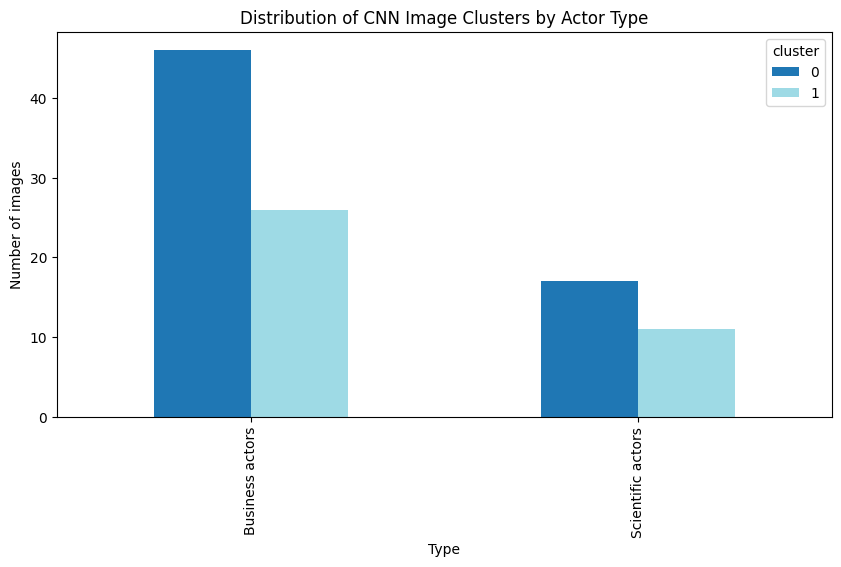

In [82]:
cluster_dist.plot(kind="bar", figsize=(10,5), colormap="tab20")
plt.ylabel("Number of images")
plt.title("Distribution of CNN Image Clusters by Actor Type")
plt.show()


# 1.4 vllm

In [85]:
import zipfile

desc_path = "/content/descriptions.zip"

with zipfile.ZipFile(desc_path, 'r') as z:
    z.extractall("/content/descriptions")   # 解压到 descriptions 文件夹

print("解压完成！文件列表：")
import os
os.listdir("/content/descriptions")



解压完成！文件列表：


['descriptions.tsv']

In [88]:
# === 2. 自动找到 TSV 或 CSV ===
desc_dir = "/content/descriptions"
files = os.listdir(desc_dir)

desc_file = None
for f in files:
    if f.endswith(".tsv") or f.endswith(".csv"):
        desc_file = f
        break

if desc_file is None:
    raise ValueError("压缩文件中没有 TSV 或 CSV 文件！")

print("读取文件：", desc_file)

# 根据格式读取
full_path = os.path.join(desc_dir, desc_file)

if desc_file.endswith(".tsv"):
    vllm_df = pd.read_csv(full_path, sep="\t")
else:
    vllm_df = pd.read_csv(full_path)

vllm_df.head()


读取文件： descriptions.tsv


,Dir,ImageID,Labels
0,media,3_671671279821398016.jpg,The image conveys a sense of community and col...
1,media,3_674113133523415040.jpg,I'm unable to identify the individuals in the ...
2,media,3_673034418605322240.jpg,The image conveys a strong advocacy for nuclea...
3,media,3_671292051875602433.jpg,The image conveys a sense of global unity and ...
4,media,3_671366298241208320.jpg,The image conveys a sense of solidarity and co...


In [89]:
# descriptions.tsv 的 ImageID 字段本身就是正确格式，不需要修改
vllm_df["ImageID"] = vllm_df["ImageID"].astype(str)

# sample_df 的 image_file 字段也要转成 str
sample_df["image_file"] = sample_df["image_file"].astype(str)

# 合并
merged_df = sample_df.merge(
    vllm_df,
    left_on="image_file",
    right_on="ImageID",
    how="left"
)

merged_df.head()


,image_file,media_key,id,author_id,text,created_at,lang,Type,Lang,Stance,objects,bow,bow_text,Dir,ImageID,Labels
0,3_674261885475164160.jpg,3_674261885475164160,674261886985195521,329628561,Our panel with @PRI_News @SycomoreAM @DemeterP...,2015-12-08T16:18:55.000Z,en,Business actors,en,For,"[{'label': 'presenter', 'score': 0.053, 'box':...","[presenter, presenter, presenter, presenter, p...",presenter presenter presenter presenter presenter,media,3_674261885475164160.jpg,The image conveys a sense of urgency and colla...
1,3_673533167819579392.jpg,3_673533167819579392,673536371810836484,3008051701,"Energy4Europe: RE-Energising our future, but f...",2015-12-06T16:15:59.000Z,en,Business actors,en,For,[],[],,media,3_673533167819579392.jpg,The image conveys an optimistic and forward-lo...
2,3_672084703390924801.jpg,3_672084703390924801,672084719190867968,3288510261,All set up: We've arrived at #COP21. Find us i...,2015-12-02T16:07:38.000Z,en,Scientific actors,en,For,[],[],,media,3_672084703390924801.jpg,The image depicts a professional exhibition sp...
3,3_671268717817294848.jpg,3_671268717817294848,671268718563995648,95687779,#Climatesolutions @veolia: In Rostock #Germany...,2015-11-30T10:05:08.000Z,en,Business actors,en,For,[],[],,media,3_671268717817294848.jpg,The image uses playful language and vibrant vi...
4,3_671902027887337474.jpg,3_671902027887337474,671902027971223552,65339733,The world needs clarity on the way to reduce g...,2015-12-02T04:01:41.000Z,en,Scientific actors,en,For,[],[],,media,3_671902027887337474.jpg,The image evokes a sense of mystery and contem...


In [90]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(t):
    if pd.isna(t):
        return ""
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

merged_df["clean_text"] = merged_df["Labels"].apply(clean_text)


In [93]:
vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=2,
    stop_words="english"
)

X = vectorizer.fit_transform(merged_df["clean_text"])


In [94]:
from sklearn.decomposition import NMF

n_topics = 2
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_


In [95]:
feature_names = vectorizer.get_feature_names_out()

def show_topics(H, n_words=10):
    for idx, topic in enumerate(H):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words-1:-1]]
        print(f"Topic {idx}: {' | '.join(top_words)}\n")

show_topics(H)


Topic 0: climate | change | environmental | global | addressing | urgency | action | collective | conference | challenges

Topic 1: energy | environment | professional | suggests | nuclear | related | ideas | formal | professionalism | setting



In [96]:
merged_df["topic"] = W.argmax(axis=1)
merged_df[["image_file", "Type", "topic"]].head()


,image_file,Type,topic
0,3_674261885475164160.jpg,Business actors,0
1,3_673533167819579392.jpg,Business actors,1
2,3_672084703390924801.jpg,Scientific actors,1
3,3_671268717817294848.jpg,Business actors,1
4,3_671902027887337474.jpg,Scientific actors,1


In [97]:
topic_compare = merged_df.groupby(["Type", "topic"]).size().unstack(fill_value=0)
topic_compare


topic,0,1
Type,,
Business actors,38,34
Scientific actors,13,15
